In [1]:
import cntk; print(cntk.__version__)

2.7


In [2]:
pwd

'/data/home/cubean/notebooks/git/ImageSimilarityUsingCntk'

In [3]:
cntk.device.all_devices()

(GPU[0] Tesla K80, CPU)

In [1]:
# -*- coding: utf-8 -*-
from helpers import *
locals().update(importlib.import_module("PARAMETERS").__dict__)

import datetime
current_time1 = datetime.datetime.now()
####################################
# Main
####################################
random.seed(0)
makeDirectory(procDir)
imgFilenamesTest  = dict()
imgFilenamesTrain = dict()

print("Split images into train or test...")
subdirs = getDirectoriesInDirectory(imgDir)
for subdir in subdirs:
    filenames = getFilesInDirectory(imgDir + subdir, ".jpg")

    # Randomly assign images into train or test
    if imagesSplitBy == 'filename':
        filenames  = randomizeList(filenames)
        splitIndex = int(ratioTrainTest * len(filenames))
        imgFilenamesTrain[subdir] = filenames[:splitIndex]
        imgFilenamesTest[subdir]  = filenames[splitIndex:]

    # Randomly assign whole subdirectories to train or test
    elif imagesSplitBy == 'subdir':
        if random.random() < ratioTrainTest:
            imgFilenamesTrain[subdir] = filenames
        else:
            imgFilenamesTest[subdir]  = filenames
    else:
        raise Exception("Variable 'imagesSplitBy' has to be either 'filename' or 'subdir'")

    # Debug print
    if subdir in imgFilenamesTrain:
        print("Training: {:5} images in directory {}".format(len(imgFilenamesTrain[subdir]), subdir))
    if subdir in imgFilenamesTest:
        print("Testing:  {:5} images in directory {}".format(len(imgFilenamesTest[subdir]), subdir))

# Save assignments of images to train or test
saveToPickle(imgFilenamesTrainPath, imgFilenamesTrain)
saveToPickle(imgFilenamesTestPath,  imgFilenamesTest)

# Mappings label <-> id
lutId2Label = dict()
lutLabel2Id = dict()
for index, key in enumerate(imgFilenamesTrain.keys()):
    lutLabel2Id[key] = index
    lutId2Label[index] = key
saveToPickle(lutLabel2IdPath, lutLabel2Id)
saveToPickle(lutId2LabelPath, lutId2Label)

# Compute positive and negative image pairs
print("Generate training data ...")
imgInfosTrain = getImagePairs(imgFilenamesTrain, train_maxQueryImgsPerSubdir, train_maxNegImgsPerQueryImg)
saveToPickle(imgInfosTrainPath, imgInfosTrain)
print("Generate test data ...")
imgInfosTest = getImagePairs(imgFilenamesTest, test_maxQueryImgsPerSubdir, test_maxNegImgsPerQueryImg)
saveToPickle(imgInfosTestPath, imgInfosTest)

# Sanity check - make sure the test and training set have no images in common
if True:
    print("Verifying if training and test set are disjoint:")
    pathsTest  = getImgPaths(loadFromPickle(imgInfosTestPath))
    pathsTrain = getImgPaths(loadFromPickle(imgInfosTrainPath))

    # Make sure the training set and test set have zero overlap
    overlap = len(pathsTrain.intersection(pathsTest))
    if overlap == 0:
        print("   Check passed: Training and test set share no images.")
    else:
        raise Exception("Training and test set share %d images." % overlap)
print("DONE.")

current_time2 = datetime.datetime.now()

print ("This step took time: %s" % (current_time2 - current_time1))


PARAMETERS: datasetName = costumebox/training/womens-costumes
Split images into train or test...
Training:    87 images in directory womens-elegant-costumes
Testing:     29 images in directory womens-elegant-costumes
Training:   209 images in directory sexy-costumes
Testing:     70 images in directory sexy-costumes
Training:    19 images in directory party-busters
Testing:      7 images in directory party-busters
Training:   105 images in directory womens-plus-size-costumes
Testing:     36 images in directory womens-plus-size-costumes
Generate training data ...
Generated image pairs for 306 query images, each with 1 positive image pair and 100 negative image pairs.
Generate test data ...
Generated image pairs for 67 query images, each with 1 positive image pair and 100 negative image pairs.
Verifying if training and test set are disjoint:
   Check passed: Training and test set share no images.
DONE.
This step took time: 0:00:00.977653


Using GPU for CNTK training/scoring.
rf_modelFilename is ResNet18_ImageNet_CNTK.model, rf_modelOutputDimension = 512, rf_inputResoluton_width = 720, rf_inputResoluton_height = 720, rf_dropoutRate = 0.5, rf_l2RegWeight = 5e-06
Training transfer learning model for 45 epochs (epoch_size_train = 420).
Training 15899204 parameters in 68 parameter tensors.
Learning rate per minibatch: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 45]: [Training] loss = 1.699569 * 420, metric = 61.19% * 420 184.144s (  2.3 samples/s);
Finished Evaluation [1]: Minibatch[1-9]: metric = 51.41% * 142;
Finished Epoch[2 of 45]: [Training] loss = 1.177969 * 420, metric = 50.00% * 420 127.677s (  3.3 samples/s);
Finished Evaluation [2]: Minibatch[1-9]: metric = 50.70% * 142;
Finished Epoch[3 of 45]: [Training] loss = 1.056361 * 420, metric = 45.24% * 420 127.559s (  3.3 samples/s);
Finished Evaluation [3]: Minibatch[1-9]: metric = 50.70% * 142;
Finished Epoch[4 of 45]: [Training] loss = 0.992353 * 420, metric 

Finished Evaluation [45]: Minibatch[1-9]: metric = 35.21% * 142;
Stored trained model at /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/proc/costumebox/training/womens-costumes/cntk.model
This step took time: 1:36:55.010644
DONE. Showing DNN accuracy vs training epoch plot.


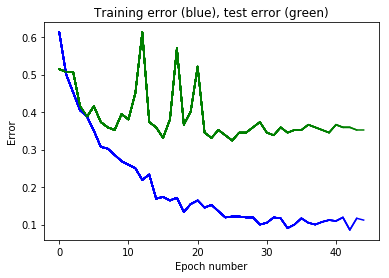

In [2]:
# -*- coding: utf-8 -*-
from helpers import *
from helpers_cntk import *
locals().update(importlib.import_module("PARAMETERS").__dict__)


################################################
# MAIN
################################################
makeDirectory(workingDir)

import datetime
current_time1 = datetime.datetime.now()

# Load data
lutLabel2Id = loadFromPickle(lutLabel2IdPath)
imgFilenamesTest  = loadFromPickle(imgFilenamesTestPath)
imgFilenamesTrain = loadFromPickle(imgFilenamesTrainPath)

# Generate cntk test and train data, i.e. (image, label) pairs and write
# them to disk since in-memory passing is currently not supported by cntk
dataTest  = getImgLabelMap(imgFilenamesTest,  imgDir, lutLabel2Id)
dataTrain = getImgLabelMap(imgFilenamesTrain, imgDir, lutLabel2Id)
if rf_boBalanceTrainingSet:
    dataTrain = balanceDatasetUsingDuplicates(dataTrain)
writeTable(cntkTrainMapPath, dataTrain)
writeTable(cntkTestMapPath, dataTest)

# Train model
printDeviceType()
print("rf_modelFilename is %s, rf_modelOutputDimension = %s, rf_inputResoluton_width = %s, rf_inputResoluton_height = %s, rf_dropoutRate = %s, rf_l2RegWeight = %s" % 
    (rf_modelFilename, rf_modelOutputDimension, rf_inputResoluton_width, rf_inputResoluton_height, rf_dropoutRate, rf_l2RegWeight))
model = train_model(cntkPretrainedModelPath, cntkTrainMapPath, cntkTestMapPath, rf_inputResoluton_width, rf_inputResoluton_height,
                    rf_maxEpochs, rf_mbSize, rf_maxTrainImages, rf_lrPerMb, rf_momentumPerMb, rf_l2RegWeight,
                    rf_dropoutRate, rf_boFreezeWeights)
model.save(cntkRefinedModelPath)
print("Stored trained model at %s" % cntkRefinedModelPath)

current_time2 = datetime.datetime.now()
print ("This step took time: %s" % (current_time2 - current_time1))

print("DONE. Showing DNN accuracy vs training epoch plot.")
plt.show() # Accuracy vs training epochs plt

In [3]:
# -*- coding: utf-8 -*-
from helpers import *
from helpers_cntk import *
locals().update(importlib.import_module("PARAMETERS").__dict__)

import datetime
current_time1 = datetime.datetime.now()
################################################
# MAIN
################################################
# Init
printDeviceType()
makeDirectory(workingDir)
model = load_model(cntkRefinedModelPath)

# Compute features for each image and write to disk
print("Featurizing test set..")
featuresTest  = featurizeImages(model, imgFilenamesTestPath,  imgDir, workingDir + "/featurizer_map.txt", "poolingLayer", run_mbsize)
print("Featurizing training set..")
featuresTrain = featurizeImages(model, imgFilenamesTrainPath, imgDir, workingDir + "/featurizer_map.txt", "poolingLayer", run_mbsize)
features = mergeDictionaries(featuresTrain, featuresTest)
for feat in list(features.values()):
    assert(len(feat) == rf_modelOutputDimension)

# Save features to file
print("Writting CNTK outputs to file %s ..." % featuresPath)
saveToPickle(featuresPath, features)
print("DONE.")
current_time2 = datetime.datetime.now()
print ("This step took time: %s" % (current_time2 - current_time1))



Using GPU for CNTK training/scoring.
Featurizing test set..
Evaluating DNN (output dimension = 512) for image 100 of 142: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes//womens-elegant-costumes/33368-gatsby.jpg
Featurizing training set..
Evaluating DNN (output dimension = 512) for image 100 of 420: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes//sexy-costumes/01458-crueldiva.jpg
Evaluating DNN (output dimension = 512) for image 200 of 420: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes//sexy-costumes/117703-gold0_1.jpg
Evaluating DNN (output dimension = 512) for image 300 of 420: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes//womens-elegant-costumes/85240-witch.jpg
Evaluating DNN (output dimension = 512) for image 400 of 420: /data/home/cubean/notebooks/git/ImageSi

Generate training data...
Statistics training data:
   Number of examples: 30906
   Number of positive examples: 306
   Number of negative examples: 30600
   Dimension of each example: 512
Generate test data...
Statistics test data:
   Number of examples: 6767
   Number of positive examples: 67
   Number of negative examples: 6700
   Dimension of each example: 512

Training...
   Start SVM training...
   Training time [labels_train]: 5387.116
   Training accuracy    = 84.52%
   Test accuracy        = 68.21%
   Updating best model.
Probability calibration positive to negative ration = 10
Wrote svm to: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/proc/costumebox/training/womens-costumes/svm.np

DONE. Showing SVM score vs probability.


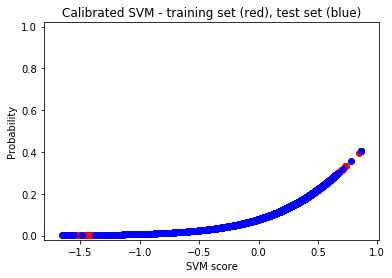

This step took time: 0:00:07.377502


In [4]:
# -*- coding: utf-8 -*-
from helpers import *
locals().update(importlib.import_module("PARAMETERS").__dict__)

import datetime
current_time1 = datetime.datetime.now()
####################################
# Main
####################################
random.seed(0)
ImageInfo.allFeatures = loadFromPickle(featuresPath)  # Load all DNN image features into memory

# Load training data
print("Generate training data...")
imgInfosTrain = loadFromPickle(imgInfosTrainPath)
#imgInfosTrain = imgInfosTrain[::50]
feats_train, labels_train = getImgPairsFeatures(imgInfosTrain, svm_featureDifferenceMetric, svm_boL2Normalize)
printFeatLabelInfo("Statistics training data:", feats_train, labels_train)

# Load test data
print("Generate test data...")
imgInfosTest = loadFromPickle(imgInfosTestPath)
#imgInfosTest = imgInfosTest[::25]
feats_test, labels_test = getImgPairsFeatures(imgInfosTest, svm_featureDifferenceMetric, svm_boL2Normalize)
printFeatLabelInfo("Statistics test data:", feats_test, labels_test)

# Perform one or more iterations of SVM training
print("\nTraining...")
bestAcc = float('-inf')
for hardNegIter in range(svm_hardNegMining_nrIterations+1):
    # Mine hard negatives
    # Note: use this functionality carefully since this will often find and wrongly annotated data to the
    #       training set and hence degrade the classifier.
    if hardNegIter > 0:
        print("Hard negative mining - iteration %d" % hardNegIter)
        if hardNegIter == 1:
            imgFilenamesTrain = loadFromPickle(imgFilenamesTrainPath)
        hardNegatives = mineHardNegatives(learner, imgFilenamesTrain, svm_hardNegMining_nrAddPerIter,
                                          svm_featureDifferenceMetric, svm_boL2Normalize, svm_hardNegMinging_maxNrRoundsPerIter)
        feats_train  += hardNegatives
        labels_train += [0] * len(hardNegatives)
        printFeatLabelInfo("   Statistics training data:", feats_train, labels_train, preString="      ")

    # Train svm
    print("   Start SVM training...")
    tstart  = datetime.datetime.now()
    learner = svm.LinearSVC(C=svm_CVal, class_weight='balanced', verbose=0)
    learner.fit(feats_train, labels_train)
    print("   Training time [labels_train]: " + str((datetime.datetime.now() - tstart).total_seconds() * 1000))
    print("   Training accuracy    = {:3.2f}%".format(100 * np.mean(sklearnAccuracy(learner, feats_train, labels_train))))
    testAcc = np.mean(sklearnAccuracy(learner, feats_test,  labels_test))
    print("   Test accuracy        = {:3.2f}%".format(100 * np.mean(testAcc)))

    # Store best model. Note that this should use a separate validation set, and not the test set.
    if testAcc > bestAcc:
        print("   Updating best model.")
        bestAcc = testAcc
        bestLearner = learner

# Calibrate probability. Set weights to balance dataset as if 10 times more negatives than positives
del learner
print("Probability calibration positive to negative ration = {}".format(svm_probabilityCalibrationNegPosRatio))
sampleWeights = getSampleWeights(labels_test, negPosRatio = svm_probabilityCalibrationNegPosRatio)
bestLearner = calibration.CalibratedClassifierCV(bestLearner, method='sigmoid', cv = "prefit") #sigmoid, isotonic
bestLearner.fit(feats_test, labels_test, sample_weight = sampleWeights)
saveToPickle(svmPath, bestLearner)
print("Wrote svm to: " + svmPath + "\n")

# Plot score vs probability of trained classifier
print("DONE. Showing SVM score vs probability.")
plotScoreVsProbability(bestLearner, feats_train, feats_test).show()

current_time2 = datetime.datetime.now()
print ("This step took time: %s" % (current_time2 - current_time1))


Loading data...
Computing pair-wise distances...
Computing distances for query image 0 of 67: 85371x-wench01.jpg..
Computing distances for query image 50 of 67: bavarian-bar-maid-womens-costume-01135.jpg..
Distance     random: top1Acc =  1.49%, top5Acc =  5.97%, meanRank = 52.54, medianRank = 55
Distance         L1: top1Acc =  8.96%, top5Acc = 23.88%, meanRank = 32.85, medianRank = 26
Distance         L2: top1Acc =  7.46%, top5Acc = 28.36%, meanRank = 32.49, medianRank = 22
Distance weightedl2: top1Acc =  7.46%, top5Acc = 25.37%, meanRank = 30.67, medianRank = 19
Visualizing results: writing images to /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/results/costumebox/training/womens-costumes//visualizations_weightedl2/
   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85371x-wench01.jpg


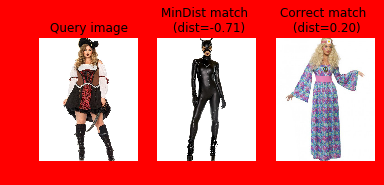

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/44351-curveywitch1.jpg


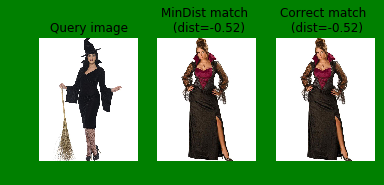

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/17440-wonderp01.jpg


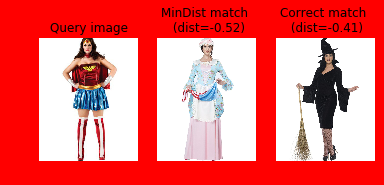

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/10105x-gisela0.jpg


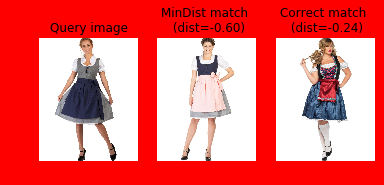

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/39660x-shell.jpg


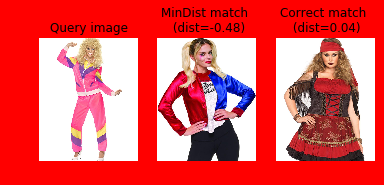

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85381x-mystic1_1.jpg


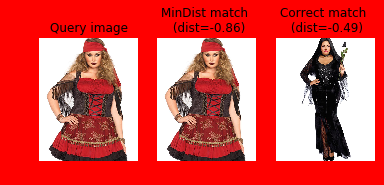

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/124045-morticia1.jpg


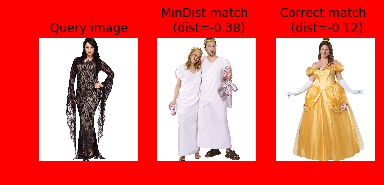

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/125635-80s.jpg


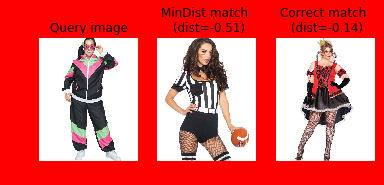

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/day-of-the-dead-womens-costume-pk156.jpg


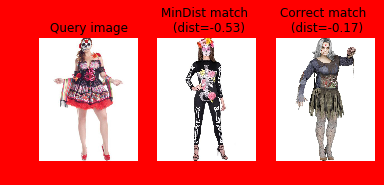

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/1106wx-sister00_1.jpg


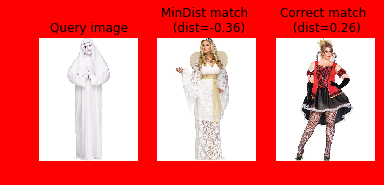

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01704-tavernplus.jpg


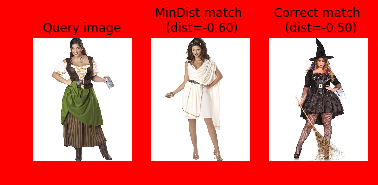

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/15001-plusvamp.jpg


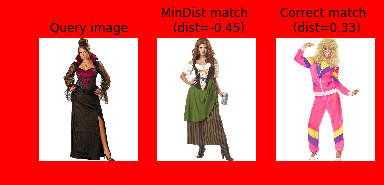

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/costumebox-erika-deluxe-oktoberfest-dirndl-plus-size-womens-costume-10110x-main.jpg


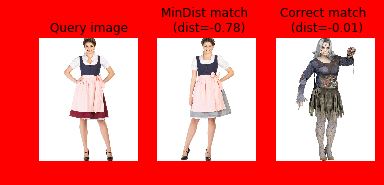

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/10109-helgaaaa.jpg


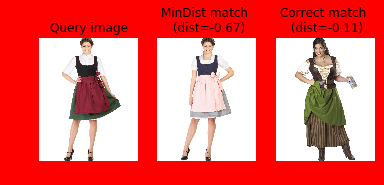

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/gretchen-beer-maid-womens-plus-size-costume-83311x.jpg


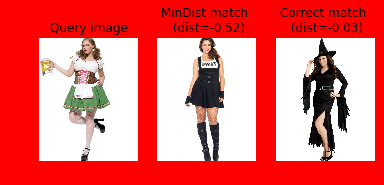

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/114535-zombie.jpg


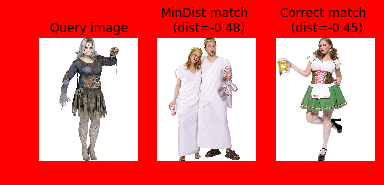

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/70596-q-flapper.jpg


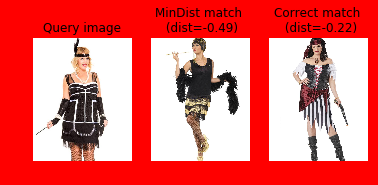

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/10639x-frightaa.jpg


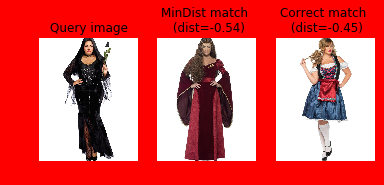

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85529x-spell00.jpg


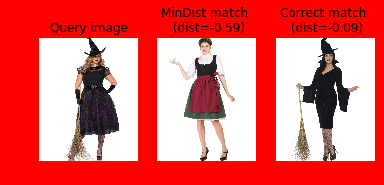

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/83850-swat1.jpg


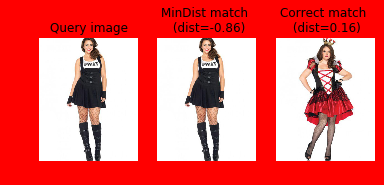

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/1424-bride-of-darkness.jpg


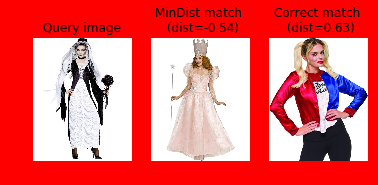

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/jailhouse-honey-womens-costume-110174.jpg


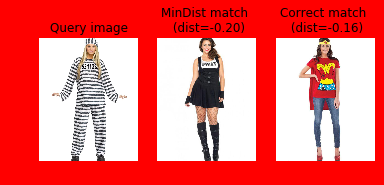

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/wonder-woman-t-shirt-costume-kit-880475.jpg


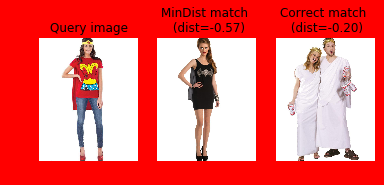

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/black-shimmery-flapper-womens-costume-125004b.jpg


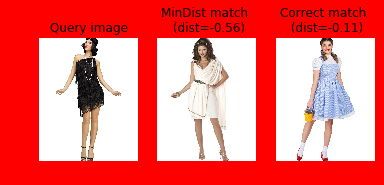

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/suicide-squad-harley-quinn-costume-kit-820078.jpg


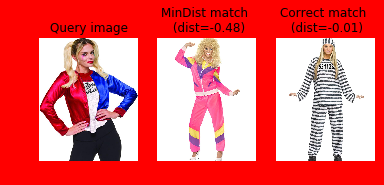

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/5427-toga.jpg


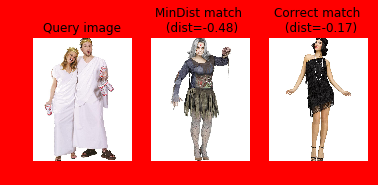

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/costumebox-girl-from-oz-deluxe-womens-costume-10115-main.jpg


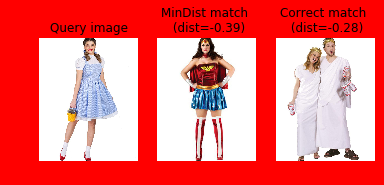

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01566_colonial1.jpg


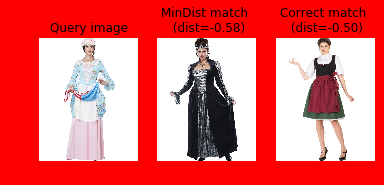

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/costumebox-leisl-oktoberfest-dirndl-womens-costume-10137-main.jpg


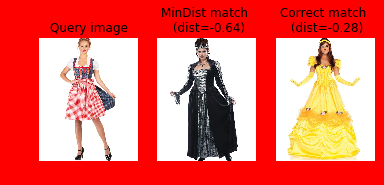

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/classic-toga-womens-costume-01151.jpg


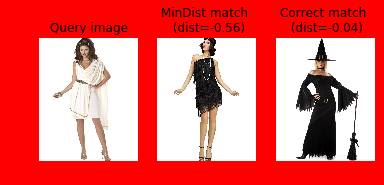

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/90157-mermaid.jpg


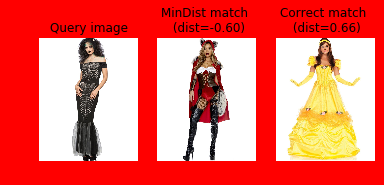

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/belle-of-the-ball-womens-costume-86707.jpg


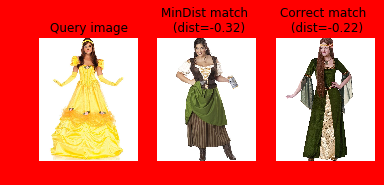

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/51044-snowwhite.jpg


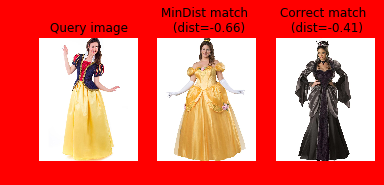

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01329-cinderella.jpg


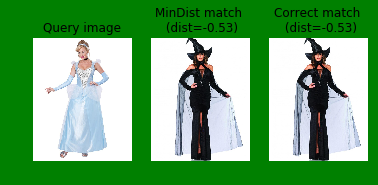

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/11040-flamenco_1.jpg


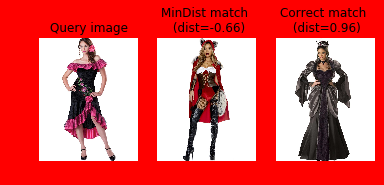

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/33368-gatsby.jpg


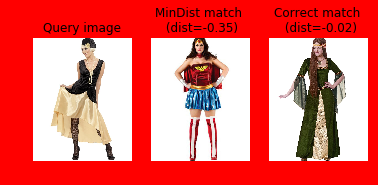

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/889954-qoh.jpg


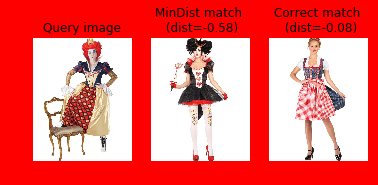

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/00808-elewitch.jpg


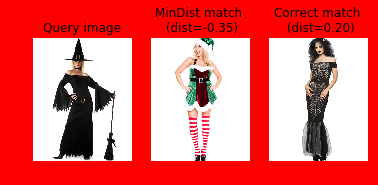

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/1022-wicked.jpg


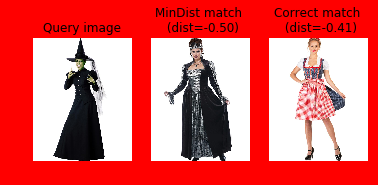

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85242-witch.jpg


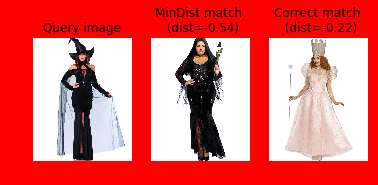

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01225-robe.jpg


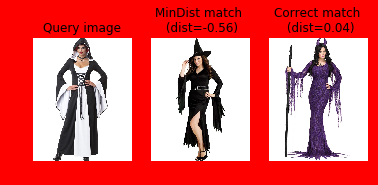

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/45489-queen1_1.jpg


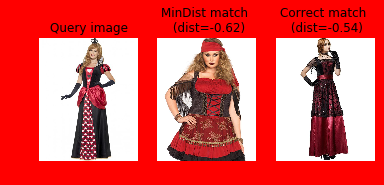

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/1056-wicked.jpg


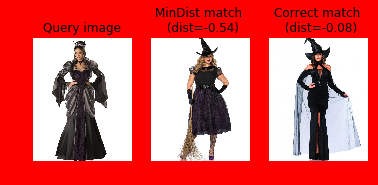

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/887383-glindawitch.jpg


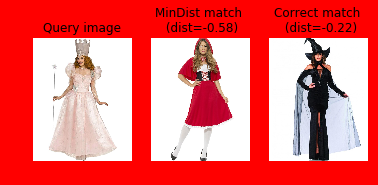

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/the-virgin-mary-womens-costume-01316.jpg


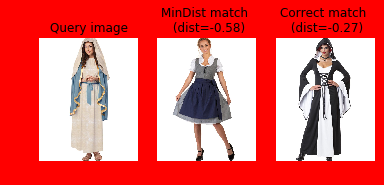

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01380_guinevere1_1.jpg


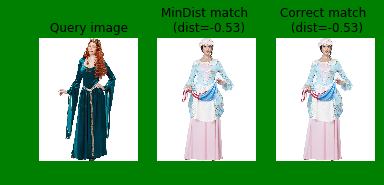

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/01456700-uptown.jpg


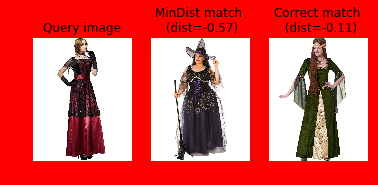

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/83895-tigress.jpg


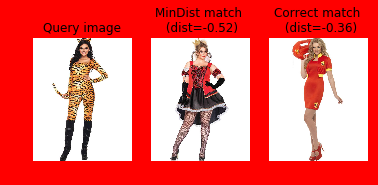

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/fringed-flapper-womens-costume-33676-main.jpg


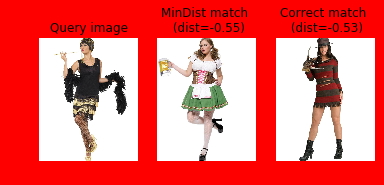

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/112001blk-jumpsuit.jpg


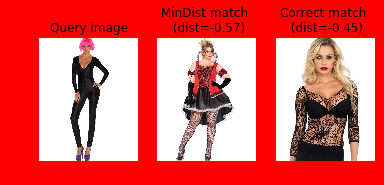

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/bavarian-bar-maid-womens-costume-01135.jpg


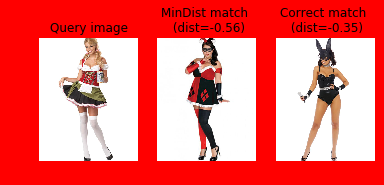

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/83157x-pirate000.jpg


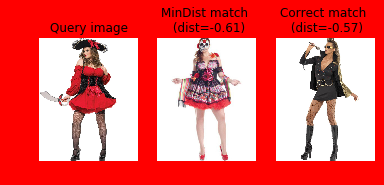

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/83924-queen.jpg


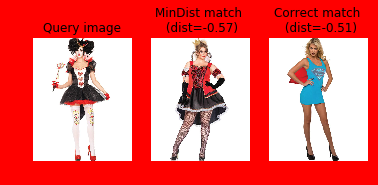

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/pk937-midweek.jpg


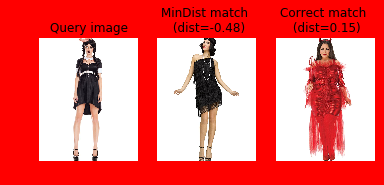

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/821032-devil.jpg


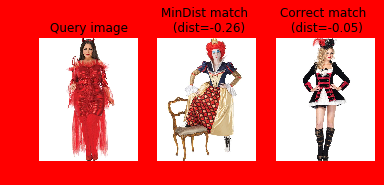

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/558777-bunny.jpg


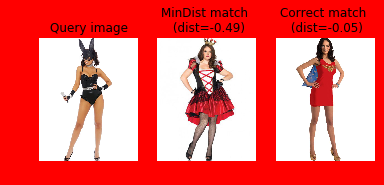

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85435-vampire.jpg


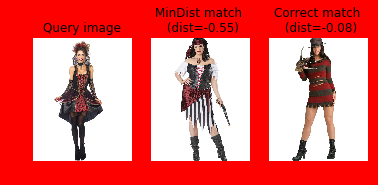

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/85222-mime.jpg


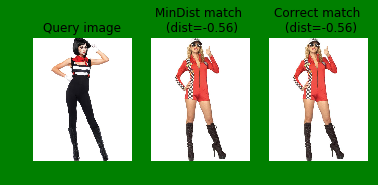

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/mrs-beetlejuice-womens-costume-880617.jpg


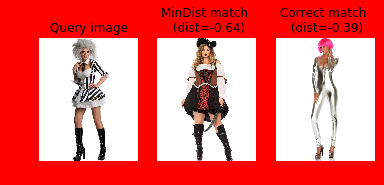

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/31969-skelton.jpg


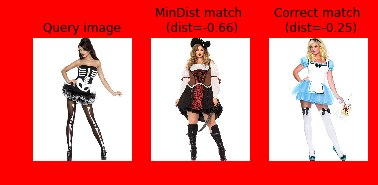

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/888655-zorro.jpg


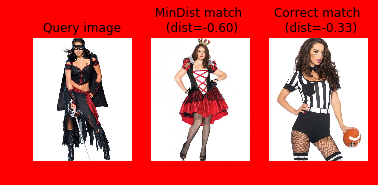

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/33794-wild-west.jpg


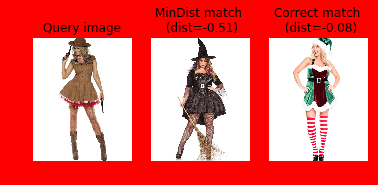

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/khaki-camo-sexy-army-girl-womens-costume-28864-main.jpg


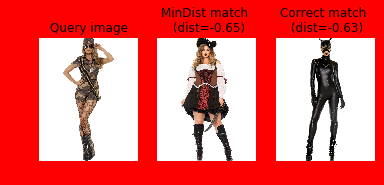

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/112001-silver.jpg


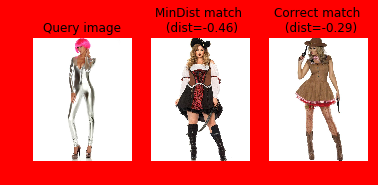

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/880586-harley.jpg


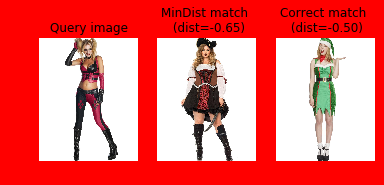

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/83609w-petticoat.jpg


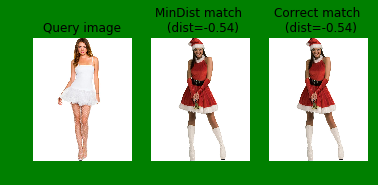

   Visualizing result for query image: /data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/1044-tiger.jpg


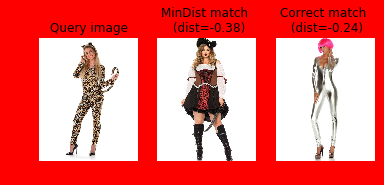

DONE.


In [5]:
# -*- coding: utf-8 -*-
from helpers import *
locals().update(importlib.import_module("PARAMETERS").__dict__)


####################################
# Parameters
####################################
distMethods = ['random', 'L1', 'L2', 'weighted'+svm_featureDifferenceMetric]  #'cosine', 'correlation', 'chiSquared', 'normalizedChiSquared']

# No need to change below parameters
boVisualizeResults  = True
boEvalOnTrainingSet = False  # Set to 'False' to evaluate using test set; 'True' to instead eval on training set
visualizationDir = resultsDir + "/visualizations_weightedl2/"



####################################
# Main
####################################
random.seed(0)

# Load trained svm
learner    = loadFromPickle(svmPath)
svmBias    = learner.base_estimator.intercept_
svmWeights = np.array(learner.base_estimator.coef_[0])

# Load data
print("Loading data...")
ImageInfo.allFeatures = loadFromPickle(featuresPath)
if not boEvalOnTrainingSet:
    imgInfos = loadFromPickle(imgInfosTestPath)
else:
    print("WARNING: evaluating on training set.")
    imgInfos = loadFromPickle(imgInfosTrainPath)

# Compute distances between all image pairs
print("Computing pair-wise distances...")
allDists = { queryIndex:collections.defaultdict(list) for queryIndex in range(len(imgInfos)) }
for queryIndex, queryImgInfo in enumerate(imgInfos):
    queryFeat = queryImgInfo.getFeat()
    if queryIndex % 50 == 0:
        print("Computing distances for query image {} of {}: {}..".format(queryIndex, len(imgInfos), queryImgInfo.fname))

    # Loop over all reference images and compute distances
    for refImgInfo in queryImgInfo.children:
        refFeat = refImgInfo.getFeat()
        for distMethod in distMethods:
            dist = computeVectorDistance(queryFeat, refFeat, distMethod, svm_boL2Normalize, svmWeights, svmBias)
            allDists[queryIndex][distMethod].append(dist)

# Evaluate
for distMethod in distMethods:
    correctRanks = []
    for queryIndex, queryImgInfo in enumerate(imgInfos):
        sortOrder = np.argsort(allDists[queryIndex][distMethod])
        boCorrectMatches = [child.isSameClassAsParent() for child in queryImgInfo.children]
        boCorrectMatches = np.array(boCorrectMatches)[sortOrder]
        positiveRank = np.where(boCorrectMatches)[0][0] + 1
        correctRanks.append(positiveRank)
    medianRank = round(np.median(correctRanks))
    top1Acc = 100.0 * np.sum(np.array(correctRanks) == 1) / len(correctRanks)
    top5Acc = 100.0 * np.sum(np.array(correctRanks) <= 5) / len(correctRanks)
    print("Distance {:>10}: top1Acc = {:5.2f}%, top5Acc = {:5.2f}%, meanRank = {:5.2f}, medianRank = {:2.0f}".format(distMethod, top1Acc, top5Acc, np.mean(correctRanks), medianRank))

# Visualize
if boVisualizeResults:
    makeDirectory(resultsDir)
    makeDirectory(visualizationDir)
    print("Visualizing results: writing images to " +  visualizationDir)

    # Loop over all query images
    for queryIndex, queryImgInfo in enumerate(imgInfos):
        print("   Visualizing result for query image: " + imgDir + queryImgInfo.fname)
        dists = allDists[queryIndex]["weightedl2"]

        # Find match with minimum distance (rank 1) and correct match
        sortOrder = np.argsort(dists)
        minDistIndex = sortOrder[0]
        correctIndex = np.where([child.isSameClassAsParent() for child in queryImgInfo.children])[0][0]
        minDist      = dists[minDistIndex]
        correctDist  = dists[correctIndex]
        queryImg     = queryImgInfo.getImg(imgDir)
        minDistImg   = imgInfos[queryIndex].children[minDistIndex].getImg(imgDir)
        correctImg   = imgInfos[queryIndex].children[correctIndex].getImg(imgDir)
        minDistLabel = imgInfos[queryIndex].children[minDistIndex].subdir

        # Visualize
        if minDistLabel == queryImgInfo.subdir:
            plt.rcParams['figure.facecolor'] = 'green' #correct ranking result
        else:
            plt.rcParams['figure.facecolor'] = 'red'
        pltAxes = [plt.subplot(1, 3, i+1) for i in range(3)]
        for ax, img, title in zip(pltAxes, (queryImg,minDistImg,correctImg),
                              ('Query image', 'MinDist match \n (dist={:3.2f})'.format(minDist), 'Correct match \n (dist={:3.2f})'.format(correctDist))):
            ax.imshow(imconvertCv2Numpy(img))
            ax.axis('off')
            ax.set_title(title)
        plt.draw()
        #plt.savefig(visualizationDir + "/" + queryImgInfo.fname.replace('/','-'), dpi=200, bbox_inches='tight', facecolor=plt.rcParams['figure.facecolor'])
        plt.show()

print("DONE.")




Using GPU for CNTK training/scoring.
Time loading image [ms]: 5
Time loading DNN [ms]: 122
Time loading SVM [ms]: 1
Time loading reference image features [ms]: 624
Time cnkt input generation [ms]: 4
Time running DNN [ms]: 206
Distance computation using weightedL2Prob distance.
Time computing 373 pair-wise distances [ms]: 90
DONE.


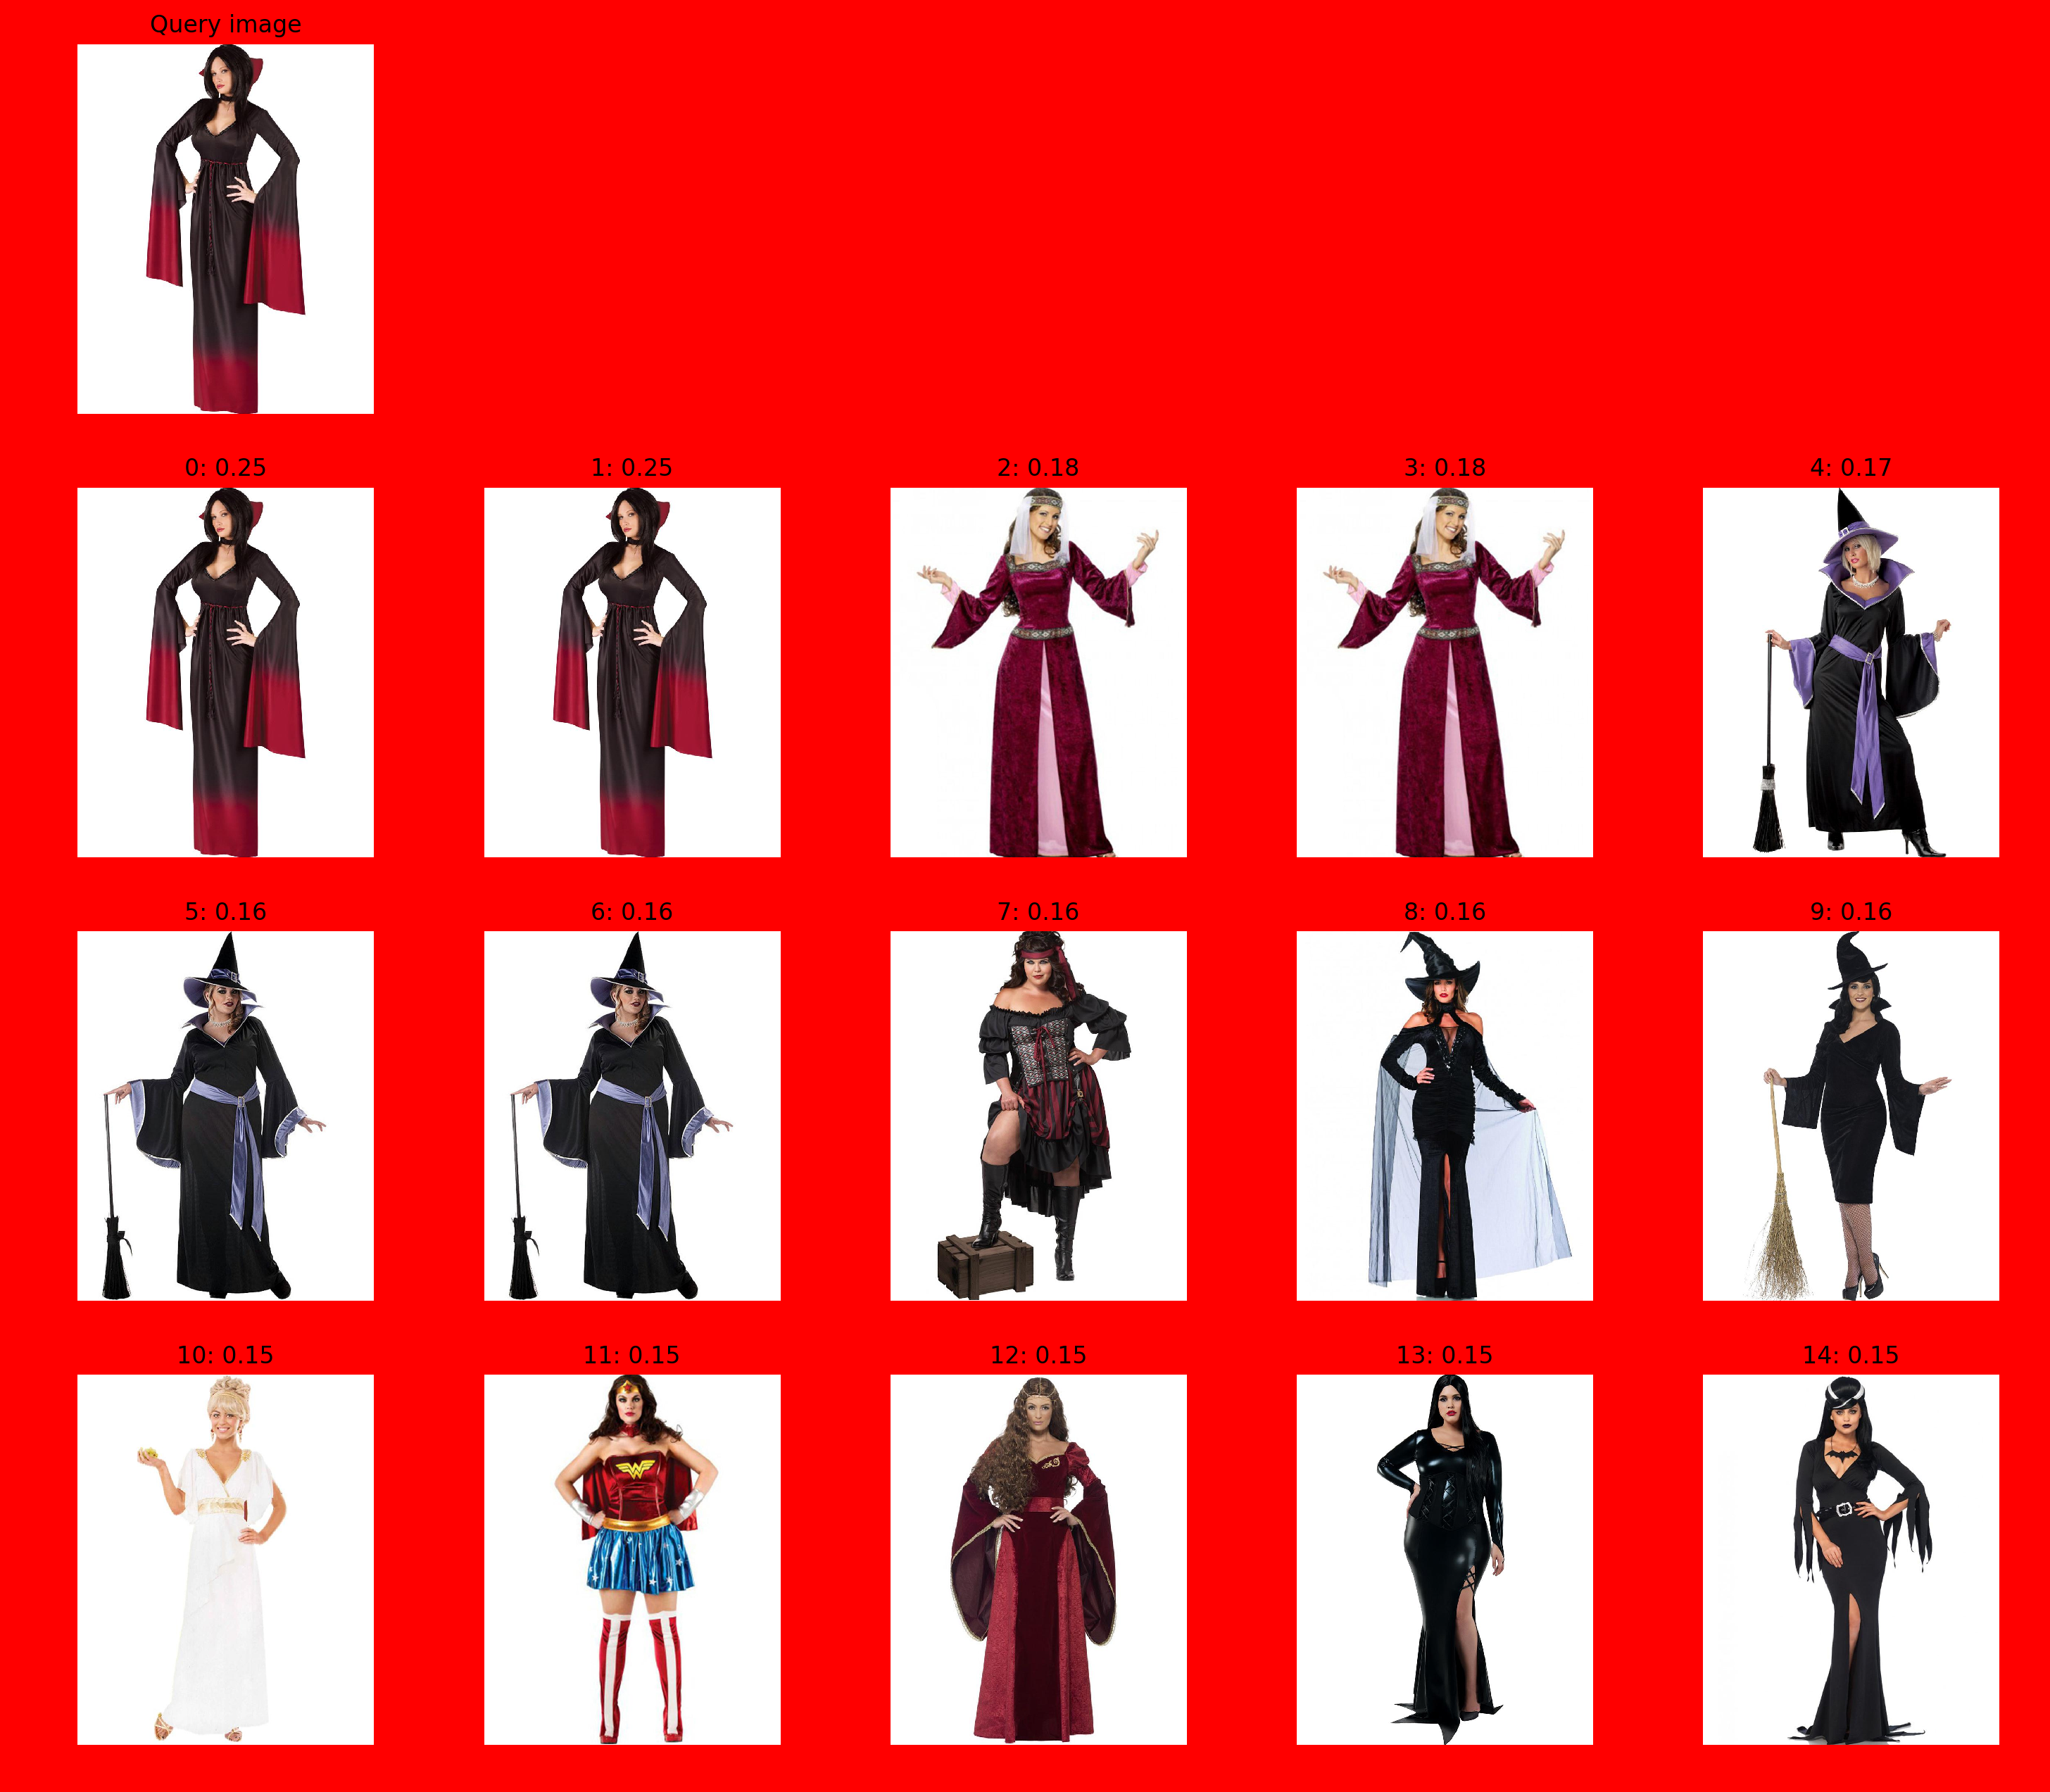

In [12]:
# -*- coding: utf-8 -*-
from helpers import *
from helpers_cntk import *
locals().update(importlib.import_module("PARAMETERS").__dict__)


####################################
# Parameters
####################################
# queryImgPath = "./data/fashionTexture/striped/95.jpg"  #pointer to an image anywhere on disk
# queryImgPath = "/data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/sexy-costumes/10287-queen.jpg"  #pointer to an image anywhere on disk
queryImgPath = "/data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/party-busters/120824-vampiress.jpg"  #pointer to an image anywhere on disk
# queryImgPath = "/data/home/cubean/notebooks/git/ImageSimilarityUsingCntk/cntk/data/costumebox/training/womens-costumes/womens-elegant-costumes/00711-juliet.jpg"  #pointer to an image anywhere on disk

# distMethod = 'weightedL2'  # Options: 'L2', 'weightedL2', 'weightedL2Prob', ...
distMethod = 'weightedL2Prob'

####################################
# Main
####################################
random.seed(0)
printDeviceType()

#-----------------------------------------------------------------------------------------------------------------------
# Data loading
#-----------------------------------------------------------------------------------------------------------------------
# Read image
tstart = datetime.datetime.now()
queryImg = imread(queryImgPath)
print("Time loading image [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))

# Load cntk model
tstart = datetime.datetime.now()
model = load_model(cntkRefinedModelPath)
node  = model.find_by_name("poolingLayer")
model = combine([node.owner])
print("Time loading DNN [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))

# Load trained svm
tstart = datetime.datetime.now()
svmLearner    = loadFromPickle(svmPath)
svmBias    = svmLearner.base_estimator.intercept_
svmWeights = np.array(svmLearner.base_estimator.coef_[0])
print("Time loading SVM [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))

# Load reference image features
tstart = datetime.datetime.now()
refImgInfos = loadFromPickle(imgInfosTrainPath)+loadFromPickle(imgInfosTestPath)
ImageInfo.allFeatures = loadFromPickle(featuresPath)
print("Time loading reference image features [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))


#-----------------------------------------------------------------------------------------------------------------------
# Computation
#-----------------------------------------------------------------------------------------------------------------------
# Prepare DNN inputs
# NOTE: CNTK rc1 (or higher) has a bug where during padding only the first dimension is assigned the pad value of 114.
#       This bug can be simulated here by padColor = [114,0,0] instead of [114, 114, 114]
tstart = datetime.datetime.now()
imgPadded = imresizeAndPad(queryImg, rf_inputResoluton, rf_inputResoluton, padColor = [114,0,0])
arguments = {
    model.arguments[0]: [np.ascontiguousarray(np.array(imgPadded, dtype=np.float32).transpose(2, 0, 1))], # convert to CNTK's HWC format
}
print("Time cnkt input generation [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))

# Run DNN model
tstart = datetime.datetime.now()
dnnOut = model.eval(arguments)
queryFeat = np.concatenate(dnnOut, axis=0).squeeze()
queryFeat = np.array(queryFeat, np.float32)
print("Time running DNN [ms]: {:.0f}".format((datetime.datetime.now() - tstart).total_seconds() * 1000))

# Compute distances between given query image and all other images
print("Distance computation using {} distance.".format(distMethod))
tstart = datetime.datetime.now()
dists = []
for refImgInfo in refImgInfos:
    refFeat = refImgInfo.getFeat()
    dist = computeVectorDistance(queryFeat, refFeat, distMethod, svm_boL2Normalize, svmWeights, svmBias, svmLearner)
    dists.append(dist)
print("Time computing {} pair-wise distances [ms]: {:.0f}".format(len(dists), (datetime.datetime.now() - tstart).total_seconds() * 1000))
print("DONE.")


#-----------------------------------------------------------------------------------------------------------------------
# Visualization
#-----------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(18, 16), dpi=200)

pltAxes = [plt.subplot(4, 5, i + 1) for i in range(4*5)]
pltAxes[0].imshow(imconvertCv2Numpy(queryImg))
pltAxes[0].set_title("Query image")
[ax.axis('off') for ax in pltAxes]

sortOrder = np.argsort(dists)
if distMethod.lower().endswith('prob'):
    sortOrder = sortOrder[::-1]
sortOrder = sortOrder[:15]
for index, (ax, refIndex) in enumerate(zip(pltAxes[5:], sortOrder)):
    currDist = dists[refIndex]
    refImgPath = refImgInfos[refIndex].getImgPath(imgDir)
    ax.imshow(imconvertCv2Numpy(imread(refImgPath)))
    ax.set_title("{}: {:2.2f}".format(index,currDist))

plt.draw()
#plt.savefig("vis.jpg", dpi=200, bbox_inches='tight')
plt.show()
